<a href="https://colab.research.google.com/github/Avassophia/Spam-Detection/blob/main/spam_email_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Email Classification
This project focuses on spam email classification, a task with strong business relevance since spam filtering protects users from phishing, reduces security risks, and saves productivity. We will implement a Multinomial Naive Bayes (MNB) classifier from scratch to detect spam emails. To validate our implementation, we compare it against scikit-learn’s built-in MultinomialNB. We aim to highlight how the choice between raw counts and weighted features affects a model’s ability to distinguish spam from legitimate messages.

In [ ]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [ ]:
#load dataset
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/enron_spam_data.csv'
df = pd.read_csv(file_path, encoding='latin1')  # 'latin1' often works for email text
#rename target column
df.rename(columns={"Spam/Ham":"Class"},inplace=True)
df.head()

Mounted at /content/drive


,Unnamed: 0,Subject,Message,Class,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


#Data Preprocessing
To clean our data, we first check for missing values. Any empty messages will be filled with an empty string (""). We then encode the target variable using binary values: 0 for ham and 1 for spam. We also observe the types of each feature.

In [ ]:
print(df.isna().sum())
df["Message"]=df["Message"].fillna("")
df["Class"]=df["Class"].map({"ham":0,"spam":1})
df.info()

Unnamed: 0     0
Subject        0
Message       52
Class          0
Date           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  33716 non-null  int64 
 1   Subject     33716 non-null  object
 2   Message     33716 non-null  object
 3   Class       33716 non-null  int64 
 4   Date        33716 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


# Splitting Data
We split our data into a training and test set using an 80-20 split.


In [ ]:
# before splitting, we shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size=int(0.8*len(df))
train_df=df[:train_size]
test_df=df[train_size:]

##Checking for Class Imbalance
Before we proceed, it is important to check for class imbalance. This would mean that there are significantly more messages of one category than the other.
Below, we see that the probability of a spam message and the probability of a ham message are both around %50, meaning our dataset is balanced.

In [ ]:
print(df["Class"].value_counts())
p_spam=round((df["Class"] == 1).sum()/len(df),3)
p_ham=round((df["Class"]==0).sum()/len(df),3)
print(f"The probability of spam is {p_spam*100}%")
print(f"The probability of ham is {p_ham*100}%")

Class
1    17171
0    16545
Name: count, dtype: int64
The probability of spam is 50.9%
The probability of ham is 49.1%


# Choosing Features Using Mutual Information

To improve the performance of our spam classifier and reduce computational complexity, we selected the top 1000 words with the highest mutual information (MI) scores. Mutual information measures the degree of association between each word and the class label. Words with high MI are those that provide the most information about whether a message is spam or ham. By focusing on these highly informative words, we reduce noise from irrelevant terms and improve overall model performance.

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif


#Find the top 1000 words with highest mutual information
vectorizer = CountVectorizer(binary=True, max_features=1000)
X = vectorizer.fit_transform(train_df["Message"])
y = train_df["Class"]

mi_scores = mutual_info_classif(X, y, discrete_features=True)


mi_df = pd.DataFrame({
    "word": vectorizer.get_feature_names_out(),
    "MI_score": mi_scores
}).sort_values(by="MI_score", ascending=False)

mi_df
vocab=mi_df["word"].to_numpy()
print("first 10 words in vocabulary: ", vocab[:10])


first 10 words in vocabulary:  ['not' 'expense' 'by' 'on' 'couple' 'for' '24' 'cost' 'point' '2002']


In [ ]:
#visualize the message column of our training set
train_df["Message"]

,Message
0,i tried calling you this am but your phone rol...
1,- bammel neon groups - fall 2001 . doc
2,"fyi , kim .\n- - - - - original message - - - ..."
3,start date : 2 / 6 / 02 ; hourahead hour : 24 ...
4,"fyi , kim .\n- - - - - original message - - - ..."
...,...
26967,"trade count , by 11 : 00 am , for last 30 days..."
26968,"i added an extra "" printable page "" button on ..."
26969,give us your feeback and\nyou could win cool c...
26970,"fyi , kim .\n- - - - - original message - - - ..."


In [ ]:
#get columns of our DataFrame as arrays (to feed into model)
train_list = train_df['Message'].tolist()
test_list=test_df['Message'].tolist()
print(train_list[:5])
print(test_list[:5])
test_lab=test_df["Class"].to_numpy()


["i tried calling you this am but your phone rolled to someone else ' s voicemail . can you call me when you get a chance ?\n- - - - - original message - - - - -\nfrom : farmer , daren j .\nsent : thursday , january 10 , 2002 2 : 06 pm\nto : hill , garrick\nsubject : re : tenaska iv\nrick ,\ni ' ve had a couple of meetings today . i ' m sorry i ' m just getting back to you . i tried to call but the voice mail said that you were unavailable . so , give me a call when you get a chance .\nd\n- - - - - original message - - - - -\nfrom : hill , garrick\nsent : wednesday , january 09 , 2002 6 : 11 pm\nto : farmer , daren j .\nsubject : re : tenaska iv\ni ' ll call you on thursday . . . what ' s a good time ?\n- - - - - original message - - - - -\nfrom : farmer , daren j .\nsent : wednesday , january 09 , 2002 3 : 03 pm\nto : hill , garrick\ncc : olsen , michael\nsubject : tenaska iv\nrick ,\nwe need to talk about the ability of ena to continue its the current role as agent of tenaska iv .\n1

## Clean Text Through Helper Function
Before putting the messages into our model, we clean the raw messages by lowercasing all words, removing headers, stripping punctuation and newlines, and normalizing spaces.

In [ ]:
import re

def clean_message(text):
    text = text.lower()
    text = re.split(r"-{2,}\s*original message\s*-{2,}", text)[0]
    text = re.sub(r"from:.*\n", "", text)
    text = re.sub(r"to:.*\n", "", text)
    text = re.sub(r"subject:.*\n", "", text)
    text = re.sub(r"sent:.*\n", "", text)

    text = text.replace("\n", " ")
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text
train_mes = [clean_message(msg) for msg in train_list]
train_mes[0]
train_lab=train_df["Class"].to_numpy()
train_lab
test_mes=[clean_message(msg) for msg in test_list]
test_mes[0]
train_lab


array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
def spam(train_mes,train_lab,test_mes):
  nwordsham = sum(len(msg) for msg, label in zip(train_mes, train_lab) if label==0)
  nwordsspam= sum(len(msg) for msg, label in zip(train_mes, train_lab) if label==1)
  train_lab=train_lab.tolist()
  train_mes = [msg.split() for msg in train_mes]
  test_mes  = [msg.split() for msg in test_mes]
  nham = train_lab.count(0)
  nspam = train_lab.count(1)
  pham=nham/len(train_lab)
  pspam=nspam/len(train_lab)
  vcounts={}
  for i in range(len(train_mes)):
    for word in train_mes[i]:
      if word not in vcounts:
        if train_lab[i]==0:
          vcounts[word]=[1,0]
        else:
          vcounts[word]=[0,1]
      else:
        if train_lab[i]==0:
          vcounts[word][0]+=1
        else:
          vcounts[word][1]+=1
  vocab = set(vcounts.keys())
  predclasses=[]
  preds=[]
  for message in test_mes:
    hamtotal=math.log(pham)
    spamtotal=math.log(pspam)
    for word in set(message):
      if word in vocab:
        pwham=(vcounts[word][0]+1)/(nwordsham+len(vocab))
        pwspam=(vcounts[word][1]+1)/(nwordsspam+len(vocab))
        m_count = message.count(word)
        hamtotal+=m_count*math.log(pwham)
        spamtotal+=m_count*math.log(pwspam)

    if hamtotal>=spamtotal:
      preds.append("ham")
      predclasses.append(0)
    else:
      preds.append("spam")
      predclasses.append(1)
  return predclasses


## Execute Spam Classifier

In [ ]:
preds=spam(train_mes,train_lab,test_mes)
print(preds)
print(test_lab)

[0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

##Evaluating Performance
First, we will visualize true positives, true negatives, false positives, and false negatives on a confusion matrix. Then, to evaluate performance, we will use three metrics- accuracy, precision, and recall.

**1. Accuracy**  
Accuracy measures how many of our predictions are correct.
- Formula:  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$  

**2. Precision**  
Precision measures, out of items classified as positive, how many are true positives?
- Formula:  
$$
\text{Precision} = \frac{TP}{TP + FP}
$$  

**3. Recall (Sensitivity)**  
Recall measures, out of all true positives, how many were correctly classified as positive?
- Formula:  
$$
\text{Recall} = \frac{TP}{TP + FN}
$$  


In [ ]:
#function to get all 3 metrics
def metrics(preds,test_lab):
  #convert DataFrame to array
  true_pos=0
  true_neg=0
  false_pos=0
  false_neg=0
  for i in range(len(test_lab)):
    if preds[i]==1 and test_lab[i]==1:
      true_pos+=1
    elif preds[i]==0 and test_lab[i]==1:
      false_neg+=1
    elif preds[i]==1 and test_lab[i]==0:
      false_pos+=1
    else:
      true_neg+=1
  acc=(true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg)
  prec=true_pos/(true_pos+false_pos)
  rec=true_pos/(true_pos+false_neg)
  return round(acc,2),round(prec,2),round(rec,2)

acc,prec,rec = metrics(preds,test_lab)
print( f"Model 1's accuracy: {acc}")
print( f"Model 1's precision: {prec}")
print( f"Model 1's recall: {rec}")


Model 1's accuracy: 0.98
Model 1's precision: 0.96
Model 1's recall: 1.0


## Evaluating Performance Through a Confusion Matrix
We use a confusion matrix to get a detailed view of the model’s performance, showing not only overall accuracy but also the types of errors (false positives and false negatives) it makes.

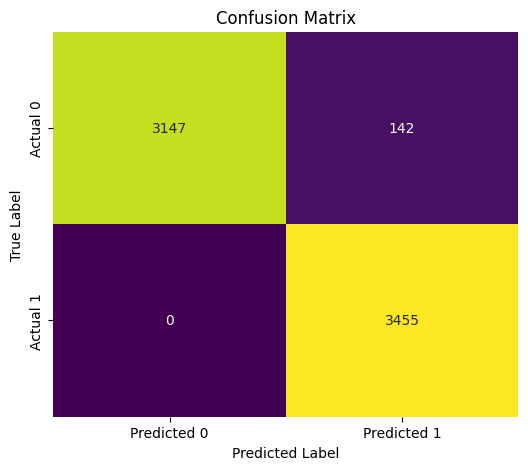

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_lab, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Through the confusion matrix, we see 0 false negatives and 142 false positives, which explains why the model’s precision is higher than its recall.

#Comparing with Scikit Learn
We now compare our from-scracth model to Scikit Learn's Multinomial Naive Bayes classifier.

In [ ]:
#try scikit learn's version of Multinomial Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score

train = [clean_message(msg) for msg in train_list]
test  = [clean_message(msg) for msg in test_list]

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train)
X_test  = vectorizer.transform(test)

clf = MultinomialNB()
clf.fit(X_train, train_lab)

preds_sklearn = clf.predict(X_test)

acc_sklearn = accuracy_score(test_lab, preds_sklearn)
print(f"Scikit-learn MultinomialNB accuracy: {acc_sklearn:.2f}")
precision = precision_score(test_lab, preds_sklearn)
print(f"Precision: {precision:.2f}")
recall = recall_score(test_lab, preds_sklearn)
print(f"Recall: {recall:.2f}")


Scikit-learn MultinomialNB accuracy: 0.98
Precision: 0.96
Recall: 1.00


## Comparing metrics of Models 1 and 2
Both models have an accuracy of 0.98, a precision of 0.96, and a recall of 1.00.
This comparison demonstrates that our from-scratch model produces equivalent results to a standard library implementation, confirming our model's correctness.

## Conclusion

In this project, we successfully implemented a Multinomial Naive Bayes (MNB) classifier from scratch to detect spam emails. After cleaning and tokenizing the email text, we calculated word probabilities for each class and predicted labels for test messages. To validate our implementation, we compared it against scikit-learn’s MultinomialNB, and achieved equivalent accuracy, precision, and recall, confirming the reliability of our from-scratch model. The project demonstrates the practical significance of spam detection in improving email security as well as enhancing overall user experience.

## Further Directions

1. Experiment with alternative text classification models such as bag-of-words, or TF-IDF, to see if they improve performance.
2. Try different classification models not specifically for text classification, such as logisitic regression, random forests, or SVM.  
3. Enhance the data preprocessing phase through techniques such as stemming, lemmatization, or handling irregular punctuation (characteristic of spam emails).



#References
Sahami, M., Dumais, S., Heckerman, D., & Horvitz, E. (1998). A Bayesian approach to filtering junk e-mail. In AAAI Workshop on Learning for Text Categorization (pp. 55–62). AAAI Press.